In [48]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_mldata
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle as sh

%matplotlib inline

In [198]:
dataset = fetch_kddcup99(subset=None, shuffle=True, percent10=True)
X = dataset.data
y = dataset.target

In [199]:
X = pd.DataFrame(X, columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serrer_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'])

In [200]:
y = pd.Series(y)

In [201]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,255,1,0,1,0,0,0,0,0
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,255,1,0,1,0,0,0,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,12,0.05,0.07,0,0,1,1,0,0
3,0,tcp,http,SF,226,188,0,0,0,0,...,2,255,1,0,0.5,0.05,0,0,0,0
4,0,tcp,http,SF,232,17052,0,0,0,0,...,91,255,1,0,0.01,0.05,0.01,0,0,0


In [202]:
X.shape

(494021, 41)

* Nominal
    Protocol_type(2), Service(3), Flag(4)

* Binary
    Land(7), logged_in(12), root_shell(14), su_attempted(15), is_host_login(21),, is_guest_login(22)

* Numeric
Duration(1), src_bytes(5),
dst_bytes(6), wrong_fragment(8),
urgent(9), hot(10),
num_failed_logins(11),
num_compromised(13),
num_root(16),
num_file_creations(17),
num_shells(18),
num_access_files(19),
num_outbound_cmds(20), count(23)
srv_count(24), serror_rate(25),
srv_serror_rate(26), rerror_rate(27),
srv_rerror_rate(28), same_srv_rate(29)
diff_srv_rate(30),
srv_diff_host_rate(31),
dst_host_count(32),
dst_host_srv_count(33),
dst_host_same_srv_rate(34),
dst_host_diff_srv_rate(35),
dst_host_same_src_port_rate(36),
dst_host_srv_diff_host_rate(37),
dst_host_serror_rate(38),
dst_host_srv_serror_rate(39),
dst_host_rerror_rate(40),
dst_host_srv_rerror_rate(41)

In [203]:
for col in X.columns:  # turn whatever columns into floats that we can
    try:
        X[col] = X[col].astype(float)
    except ValueError:
        pass

In [204]:
X = pd.get_dummies(X, prefix=['protocol_type_', 'service_', 'flag_'], drop_first=True)

In [205]:
X.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,1032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,226.0,188.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,232.0,17052.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [206]:
X.shape

(494021, 115)

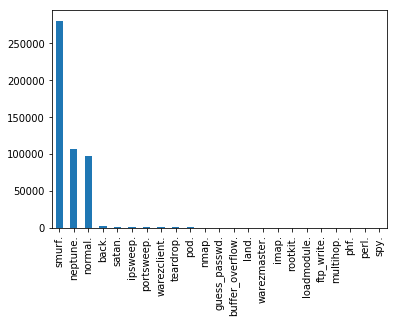

In [207]:
y.value_counts().plot(kind='bar')

In [208]:
# Let's try to make this a bit easier to manage

under_represented_attacks = [a for a in y.unique() if a not in ['smurf.', 'neptune.', 'normal.']]
under_represented_attacks

['guess_passwd.',
 'portsweep.',
 'back.',
 'satan.',
 'buffer_overflow.',
 'warezclient.',
 'ipsweep.',
 'teardrop.',
 'multihop.',
 'pod.',
 'nmap.',
 'land.',
 'ftp_write.',
 'phf.',
 'imap.',
 'rootkit.',
 'warezmaster.',
 'loadmodule.',
 'spy.',
 'perl.']

In [209]:
y = y.replace(to_replace=[under_represented_attacks], value='other')

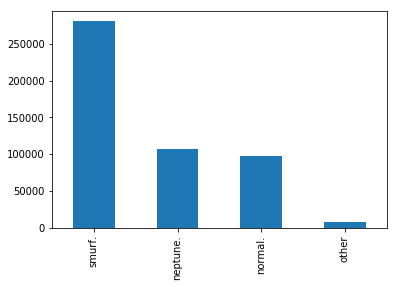

In [210]:
y.value_counts().plot(kind='bar')

In [211]:
from sklearn.linear_model import SGDClassifier

In [212]:
sgdclf = SGDClassifier()

In [213]:
%%time
sgdclf.fit(X, y)

CPU times: user 7.35 s, sys: 575 ms, total: 7.92 s
Wall time: 8.76 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [214]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgdclf, X, y, scoring='accuracy', cv=5)

In [215]:
scores.mean()

0.91010778141463378

In [216]:
# How about a Random Forest?
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

scores = cross_val_score(rf, X, y, scoring='accuracy', cv=5)

np.mean(scores)  # nice

0.99976519181553447

In [217]:
from sklearn.pipeline import Pipeline  # now with some dimension reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pipe = Pipeline(steps=[('pca', pca), ('model', rf)])

In [218]:
scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=5)

np.mean(scores)   # basically just as good

0.99947168200493164

---
### History of Artificial Intelligence and Deep Learning 
<a name="history"></a>

<img src=http://i.imgur.com/8cqbWr1.png>

As Data Scientists, it's hard avoid the hype associated with Neural Networks, Deep Learning, and Artificial Intelligence. Deep Learning has made significant progress in fields where progress had been stalled for a while. As Applied ML Practioners, it is a useful component of our jobs to differentiate hype from real scientific advancements which can be used in industry. 

- **Aritficial (General) Intelligence** is the holy grail of Computer Science. The ultimate goal of AI is to build agents that mimic different forms of intelligence. AGI specifically refers to agents matching human intelligence. 


- At the most abstract level, **Neural Networks** are function approximators that map some input to output. Compared to other ML algorithms we have studied so far, they are more complex function approximators with nonlinearities in between. It is easiest to think of Neural Networks as composition of functions that can be learnt using _gradient descent_. In the equation below, $f^i$s represent non-linear functions. 
 
$$ f^n \circ ... \circ f^2(f^1(f^0(x))) = y$$

- **Deep Learning** thus refers to Neural Networks with high degree of compositions. The _depth_ in Deep Learning refers to this very fact. Current advances in AI are driven by progress in Deep Learning. 

<img src=http://beamandrew.github.io//images/deep_learning_101/nn_timeline.jpg> 

Neural Networks have been around for a while. They have a very rich history, filled with ups and downs. **The current breakthroughs in Neural Networks and Deep Learning started in 2012. Geoffery Hinton and his students at University of Toronto applied Deep Neural Networks trained on GPUs to achieve state of the art results on the image classification challenge, ImageNet.** Intial advances in Neural Networks had the biggest applications in Computer Vision and Speech Recognition. 

<img src=https://www.bdti.com/sites/default/files/insidedsp/articlepix/201608/WaveHistory.jpg>

While many of the Neural Network algorithms have been around for a while, most crucial components for pervasiveness of Deep Learning right now are: ability to collect **massively labeled datasets** and availability of **parallel computing with GPUs and cloud computing**. 


Given their pervasiveness, however, it is important to seperate **hype from scientific progress.** In this vein, **the <a href=https://www.eff.org/ai/metrics> Electronic Frontier Foundation (EFF) </a> has created a project to keep track of the scientific progress being made across different domains of Machine Learning.** 

---
#### Computer Vision 
<img src= https://www.eff.org/files/images/imagenet.jpg>
_<center> Example of Images from the ImageNet Dataset </center>_

In Computer Vision, **ImageNet was one of the benchmarks for measuring progress in image classfication.** The challenge involved correctly labeling and localizing objects in the ImageNet dataset which included around 1000 categories. 

<img src=http://i.imgur.com/0VykLhf.png>

The progress on **ImageNet Classification challenge has surprassed human performance.** This has been mostly driven by advances in Deep Neural Networks. 

While image classification has made a lot of progress on key datasets, comprehending an image requires more than just labeling what object are in the image. According to the EFF, **image comprehension "requires both sophisticated image recognition, language, and world-modelling."** The computer vision research community tests progress of their algorithms on several different datasets generated for Visual Question Answering (VQA). 

<img src=https://www.eff.org/files/images/vqa.jpg>

AI for complete Image Comprehension is still an open problem in the research community.

<img src=http://i.imgur.com/bGxbbYg.png>

---
#### Natural Language Processing and Speech Recognition

**Language Modeling** is an important for building agents that effectively comprehend natural language and communicate with humans and other agents. Building language models requires **predicting the next word in a discourse**. 

<img src=http://i.imgur.com/tYbF3mp.png>

_<center> There has been steady progress in Language Modeling driven by Neural Networks but AI agents are not cose to matching human performance </center>_

Similarly, for **Machine Translation**, Neural Networks have been useful for solving technical problems. However, there is still progress to be made in order to match human translators. 

<img src=http://i.imgur.com/tHM9ZaG.png>

Conversation is another classic test for measuring progress in AI. 
<img src=https://www.eff.org/files/images/loebner.png>

While chatbots are all the hype right now, **AI based conversational agents are still an open problem.** There is more success to be had in specialized chatbots that can't conduct general conversations but are domain specific and may have a human in the loop. 

<img src=http://i.imgur.com/vqgfatf.png>

While problems in NLP are still far from matching human performance, **Speech Recognition has reached a point of matching human performance on benchmark datasets.** Amongst the large tech companies, this has led to an arms race to build personal assistants powered by speech recognition. 

<img src=http://i.imgur.com/1ermgxI.png>

---
#### Game Playing 

Another set of metrics to judge progress towards AGI can involve building agents that learn to play abstract games. According to the EFF: 

> In principle, games are a sufficiently open-ended framework that all of intelligence could be captured within them. We can imagine a "ladder of games" which grow in sophistication and complexity, from simple strategy and arcade games to others which require very sophisticated language, world-modelling, vision and reasoning ability. At present, published reinforcement agents are climbing the first few rungs of this ladder.

<img src=http://www.kurzweilai.net/images/Game-3-of-The-Ultimate-Go-Challenge.png>  

As you may be aware, Reinforcement Learning agents have made significant progress towards solving abstract strategic games like Chess and Go and achieve superhuman performance. However, there is still progress to be made in games with some level of stochasticity and more than three dimensions.   

<img src=http://i.imgur.com/zsM8ORG.png>


<a href=https://www.eff.org/ai/metrics> EFF AI Progress Metrics </a>
> **Exercise:** With a partner, explore AGI/ML problems that were not discussed and their potential commercial applications and the progress that has been made on them. 

---
### Review: Linear, Logistic Regression
<a name="review"></a>


<details>
<summary> **Check for Understanding**: What is Linear Regression? </summary>

Recall in linear regression, we are predicting a **continuous value** from our indpendent variables. Given a feature matrix, $X \in \mathbb{R}^{p x n} $, our linear regression model predicts continuous values using the following **score function**: 
$$ \hat{y}= \theta^TX + \theta_0 $$ 

For linear regression, we are optimizing the MSE loss function: 
<p></p>

$$ \sum_i (y_i - \hat{y}_i)^2 $$

<p></p>

We can compute the _optimal_ values of $\theta$ using **gradient descent** or through direct computation of the normal equations. 


</details>

---

<details>
<summary> **Check for Understanding**: What is Logistic Regression? </summary>

Recall in logistic regression, we are predicting a **categorical value** from our indpendent variables. Given a feature matrix, $X \in \mathbb{R}^{p x n} $, we first use following **score function** to compute the "scores": 

<p></p>

$$ \theta^TX + \theta_0 $$ 
<p></p>


We then apply the **sigmoid** function to convert the scores into probabilities. 

<img src=http://i.imgur.com/MFdDBsR.png>

We then optimize the cross-entropy loss function:
<p></p>



$$ -\dfrac{1}{N}\sum_i y_i log(p_i) + (1-y_i) log(1-p_i) $$

<p></p>
We can compute the _optimal_ values of $\theta$ using **gradient descent**.  


</details>

---

> **Softmax Regression**: A generalization of binary logistic regression is the Softmax Classifier. for multiple classes. Given a $ X \in \mathbb{R}^{p x n}$, we now have a weight matrix $\theta \in \mathbb{R}^{p x k}$ where $k$ is the number of classes. Hence the score function is given by: 
<p> 
$$ s_i = \theta^Tx_i + \theta_0 $$
</p>
<p> 
</p>
<p>
To generate probability distribution over each of the K classes, we normalize our score function using exponential. Hence, we obtain probability scores. The probability of data point $i$ being in class $k$ is given by: 
</p>
<p>
$$ p^k_i =\dfrac{e^{s^k_i}}{\sum_k e^{s^k_i}} $$
</p>
<p>
We then optimize this using a generalized version of binary cross entropy. 
</p>
<p>
$$ -\dfrac{1}{N} \sum_i \sum_k y^k_{i} log(p^k_i) $$
</p>
<p>
Check out this simpler pictorial representation of this process. 
</p>
<img src=http://i.imgur.com/a0bdksC.png>

The linear models above are great for interpretability and often serve as good baselines. However, they struggle to model nonlinear data unless we explicitly include interaction terms. Here are just few examples of linear models struggling with non-linear problems. 

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from itertools import product

%matplotlib inline

In [12]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt 

def plot_decision_boundary(pred_func, X, y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.spectral_r)
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap=plt.cm.spectral_r)

def make_multiclass(N=100, D=2, K=3):
   
    """Citation Credit: Andrej Karpathy"""
   
    N = N # number of points per class
    D = D # dimensionality
    K = K # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in xrange(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

def plot_activation(activation, name):
    x = np.linspace(-5, 5, num=100)
    sig = map(activation, x)
    plt.plot(x, sig, label=name)
    plt.legend()
    plt.axhline(0, linestyle='--', c='grey')
    plt.axvline(0, linestyle='--', c='grey')

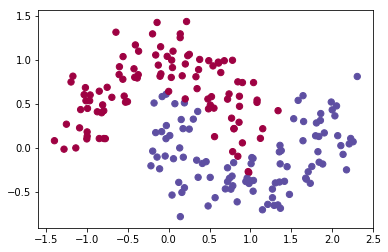

In [13]:
X, y = make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [14]:
moons_logit = LogisticRegression()
moons_logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

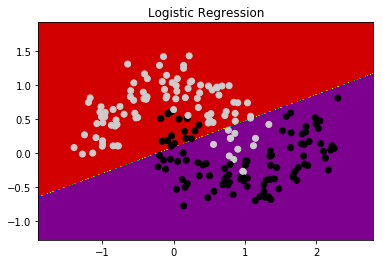

In [15]:
plot_decision_boundary(lambda x: moons_logit.predict(x), X, y)
plt.title("Logistic Regression")

In [16]:
print "Logistic Regression Accuracy on the Moon Dataset: {}".format(moons_logit.score(X, y))

Logistic Regression Accuracy on the Moon Dataset: 0.86


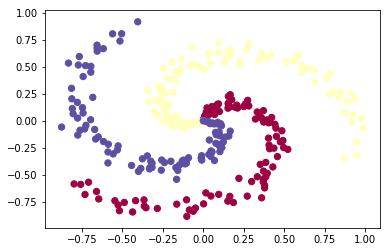

In [17]:
X, y = make_multiclass()

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [18]:
multi_logit = LogisticRegression()
multi_logit.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Softmax Classifier Accuracy on the Spiral Data: 0.52


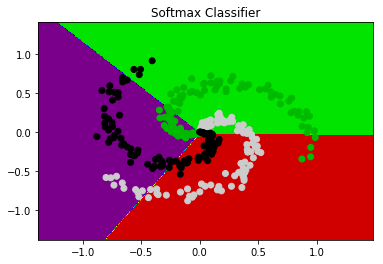

In [19]:
plot_decision_boundary(lambda x: multi_logit.predict(x), X, y)
plt.title("Softmax Classifier")
print "Softmax Classifier Accuracy on the Spiral Data: {}".format(multi_logit.score(X, y))

---
### Introduction to Feedforward Neural Networks 
<a name="play"></a>

Given the limitations of linear classifiers in modeling complex data, we need better parametric models. One example of such models are **feed forward neural networks**. As mentioned in the beginning, a neural network is a composition of many different functions: 

$$ f^n \circ ... \circ f^2(f^1(f^0(x))) = y$$

Function composition can also be described as a **directed acyclic graph.**

<img src=http://i.imgur.com/w7bDvXq.png>

The simplest unit of computation in FFNs is a **neuron** or a **node**. Each neuron or node receives input from multiple neurons in the previous **layer**. These inputs are combined together with **weights.**

<img src=http://i.imgur.com/shCc5xE.png>

For each neuron, we apply an activation function. Hence, in order to calculate a neuron in the first layer, we have: 

$$ f(\sum_{p}\theta_ix_i  + \theta_0)$$

```python

def calculate_one_neuron(inputs, weights, bias, activation):
    """ 
    
    assume inputs, weights are 1-D arrays
    bias is number
    activation is an element wise function 
    
    """
    linear_combination = inputs.dot(weights) + bias
    neuron = activation(linear_combination)
    return neuron
    
    
```


### Neural Network Activations 

**Activations or non-linearities** are the defining feature of neural networks. There are three primary activations and non-linearites that are used across different neural networks. 

---

**Sigmoid**: We have seen the sigmoid non-linearity before. It was the workhorse activation function for deep learning until recently. 
$$ \sigma(x) = \dfrac{1}{1 + e^{-x}} $$


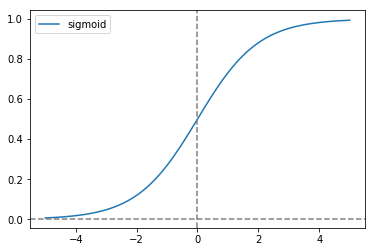

In [20]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

plot_activation(sigmoid, 'sigmoid')

---

**Tanh**: The tanh squashes a real valued number in $[-1,1]$. It is the sigmoid but centered around zero.  In practice, people prefer tanh over sigmoid because it normalizes the data around 0 and hence layers will have mean 0 which will be consistent with the normalized input. 

$$ \tanh(x) = \dfrac{e^x - e^{-x}}{e^x + e^{-x}} = 2\sigma(2x) - 1 $$

---
**ReLu:** Rectified Linear Units are the most popular activation function since 2012. They greatly increase convergence of neural networks when compared to the other two non-linearities discussed above. We will go deeper into this when we talk about the derivatives of these functions. However, given the nature of the activation, you may have a lot of dead neurons. In practice, generally 40% of your neurons may be dead with ReLu. 

$$ ReLU(x) = max(0, x) $$

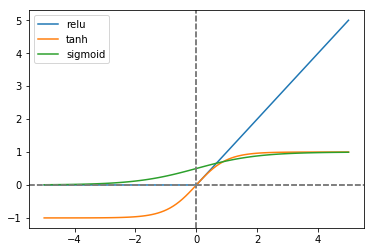

In [22]:
def tanh(x):
    return 2*sigmoid(2*x) - 1

def relu(x):
    return np.maximum(0, x)

plot_activation(relu, 'relu')
plot_activation(tanh, 'tanh')
plot_activation(sigmoid, 'sigmoid')

### Neural Network Implementation from Scratch

Let's build a Neural Network from scratch to consolidate our understanding of these individual pieces. We will build a neural network with one hidden layer from scratch to apply the concepts we just learned to solve the moons dataset. 

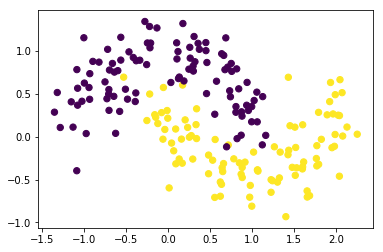

In [23]:
np.random.seed(0)
X, y = make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y)

In [29]:
net = MLPClassifier(hidden_layer_sizes=(1,))

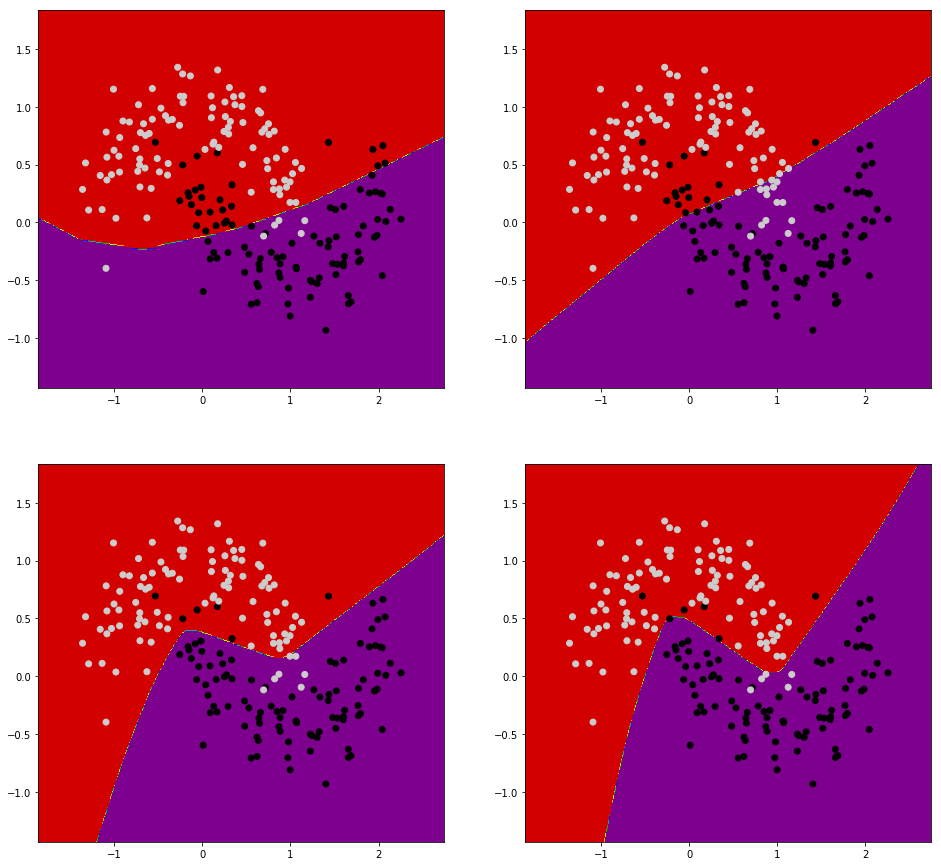

In [45]:
plt.figure(figsize=(16, 32))
hidden_layer_dims = [(10,), (100,), (1000,), (2000,)]
for i, hid_dims in enumerate(hidden_layer_dims):
    plt.subplot(4, 2, i+1)
    model = MLPClassifier(hidden_layer_sizes=hid_dims)
    model.fit(X, y)
    plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.show()

In [75]:
# Back to KDD

net = MLPClassifier(hidden_layer_sizes=(100,))  # a single layer NN

scores = cross_val_score(net, X, y, scoring='accuracy', cv=5)

In [76]:
np.mean(scores)  # very nice

0.9955346051312931

In [ ]:
# Object detection using Convolutional Neural Nets

In [220]:
from glob import glob
from pylab import imread, imsave, subplot, imshow, title, gray, figure, show, NullLocator
from numpy import mean, cov, dot, linalg, size, argsort
import PIL
from PIL import Image
from keras.utils import np_utils

In [543]:
# read in the images

images_X = np.array([])
images_y = []
code_to_target = {}
num_classes = 0
size = 32, 32
for folder in glob('data/objects/*'):
    name_of_object= folder.split('/')[-1]
    
    if name_of_object not in ['Motorbikes', 'octopus', 'accordion', 'stop_sign', 'bill_gates']:
        continue
    code_to_target[num_classes] = name_of_object
    print name_of_object
    for f in glob(folder+'/*'):  # only take the first 20 images
        img = Image.open(f)
        img = img.resize(size, Image.ANTIALIAS) # resize image to 32 by 32 for ease
        img.save(f, "JPEG") # resave the image back to the folder
        row = imread(f) # load an image  # load it into numpy
        row = np.expand_dims(row, axis=0)
        if images_X.shape[0] != 0 and row.shape == (1, 32, 32, 3):
            images_y.append(num_classes)
            images_X = np.vstack((images_X,row))
        elif images_X.shape[0] == 0:
            images_X = row
            images_y.append(num_classes)
    num_classes += 1
    
images_y = np.array(images_y)

accordion
bill_gates
Motorbikes
octopus
stop_sign


In [544]:
# normalize inputs from 0-255 to 0.0-1.0
images_X = images_X.astype('float32')
images_X = images_X / 255.0

images_y = np_utils.to_categorical(images_y)
num_classes = images_y.shape[1]

In [545]:
images_X.shape, images_y.shape

((1223, 32, 32, 3), (1223, 5))

In [546]:
X_train, X_test, y_train, y_test = train_test_split(images_X, images_y)

In [547]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [548]:
# create the model
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(32, 32, 3), border_mode='same', activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, (3, 3), activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_constraint=<keras.con..., activation="relu", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", kernel_constraint=<keras.con...)`
  """
/Users/sinanozdemir/Desktop/blackhat-vegas-ml/bh-env/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_constraint=<keras.con...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 3)         9248      
_________________________________________________________________
dropout_46 (Dropout)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 3)         9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 16, 1)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_47 (Dropout)         (None, 512)               0         
__________

In [549]:
y_train.shape

(917, 5)

In [550]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 917 samples, validate on 306 samples
Epoch 1/25
917/917 [==============================] - 2s - loss: 0.8763 - acc: 0.6783 - val_loss: 0.6118 - val_acc: 0.8170
Epoch 2/25
917/917 [==============================] - 1s - loss: 0.5714 - acc: 0.8310 - val_loss: 0.4432 - val_acc: 0.8399
Epoch 3/25
917/917 [==============================] - 1s - loss: 0.4788 - acc: 0.8506 - val_loss: 0.4500 - val_acc: 0.8562
Epoch 4/25
917/917 [==============================] - 1s - loss: 0.4576 - acc: 0.8561 - val_loss: 0.3414 - val_acc: 0.9020
Epoch 5/25
917/917 [==============================] - 1s - loss: 0.3708 - acc: 0.8800 - val_loss: 0.4413 - val_acc: 0.8431
Epoch 6/25
917/917 [==============================] - 1s - loss: 0.3714 - acc: 0.8757 - val_loss: 0.2610 - val_acc: 0.9052
Epoch 7/25
917/917 [==============================] - 1s - loss: 0.3059 - acc: 0.8986 - val_loss: 0.2671 - val_acc: 0.9216
Epoch 8/25
917/917 [==============================] - 1s - loss: 0.2705 - acc: 0.9051 - val_l

In [551]:
url = 'data/stop.jpg'
image = imread(url) # load an image
image.shape

(1200, 1800, 3)

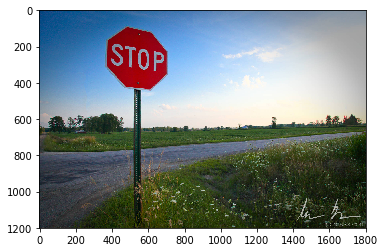

In [552]:
imshow(image)

400 50


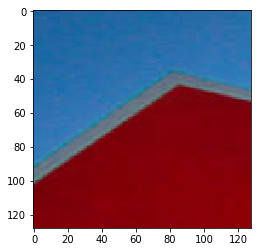

In [553]:
import random
random_x_coordinate = random.choice(range(1,image.shape[0]))
random_y_coordinate = random.choice(range(1,image.shape[0]))  # choose a random starting point
random_x_coordinate, random_y_coordinate = 400, 50
subset = image[random_y_coordinate:random_y_coordinate+128,random_x_coordinate:random_x_coordinate+128,]
print random_x_coordinate, random_y_coordinate
imshow(subset)

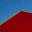

In [554]:
f = 'images/new.jpg'
img = Image.fromarray(subset, 'RGB')
img = img.resize(size, Image.ANTIALIAS) # resize image to 32 by 32 for ease
img.save(f, "JPEG") # resave the image back to the folder
row = imread(f) # load an image  # load it into numpy
row = np.expand_dims(row, axis=0)
img

In [555]:
row = row.astype('float32')
row = row / 255.0

In [556]:
code_to_target[np.argmax(model.predict(row))], max(model.predict(row)[0])

('bill_gates', 0.6322276)

In [557]:
def predict_window(x_coordinate, y_coordinate, window_size=128, resize_to=(32,32)):
    subset = image[y_coordinate:y_coordinate+window_size,x_coordinate:x_coordinate+window_size,]
    img = Image.fromarray(subset, 'RGB')
    img = img.resize(size, Image.ANTIALIAS) # resize image to 32 by 32 for ease
    f = 'images/here.jpg'
    img.save(f, "JPEG") # resave the image back to the folder
    row = imread(f) # load an image  # load it into numpy
    row = np.expand_dims(row, axis=0)
    imshow(img)
    row = row.astype('float32')
    row = row / 255.0
    proba = max(model.predict(row)[0])
    return code_to_target[np.argmax(model.predict(row))], proba

('stop_sign', 0.99992156)

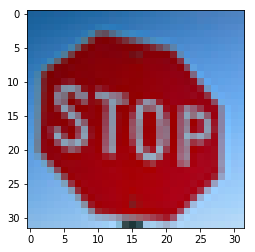

In [558]:
predict_window(350,50,400)

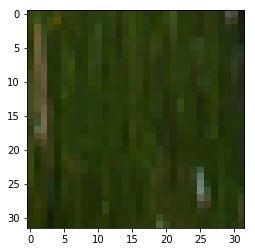

In [559]:
window_size = 400
step = 50
threshold = .999
found = []
for x in range(1,image.shape[0]-window_size, step):
    for y in range(1,image.shape[1]-window_size, step):
        try:
            prediction, proba = predict_window(x,y,window_size)
            if proba >= threshold:
                found.append((x, y, window_size, prediction, proba))
        except:
            pass

In [560]:
found

[(351, 51, 400, 'stop_sign', 0.99990737),
 (351, 101, 400, 'stop_sign', 0.99974614),
 (351, 151, 400, 'stop_sign', 0.99929214)]

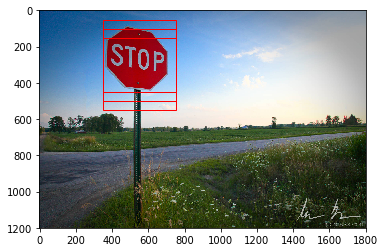

In [561]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a Rectangle patch
for f in found:
    rect = patches.Rectangle((f[0],f[1]),f[2],f[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

# Add the patch to the Axes


plt.show()

In [562]:
def magic(url, window_size=200, step=50, threshold=.99):
    image = imread(url) # load an image
    image.shape
    found = []
    def predict_window(image, x_coordinate, y_coordinate, window_size=128, resize_to=(32,32)):
        subset = image[y_coordinate:y_coordinate+window_size,x_coordinate:x_coordinate+window_size,]
        img = Image.fromarray(subset, 'RGB')
        img = img.resize(size, Image.ANTIALIAS) # resize image to 32 by 32 for ease
        f = 'images/here.jpg'
        img.save(f, "JPEG") # resave the image back to the folder
        row = imread(f) # load an image  # load it into numpy
        row = np.expand_dims(row, axis=0)
        row = row.astype('float32')
        row = row / 255.0
        proba = max(model.predict(row)[0])
        return code_to_target[np.argmax(model.predict(row))], proba
    for x in range(1,image.shape[0]-window_size, step):
        for y in range(1,image.shape[1]-window_size, step):
            try:
                prediction, proba = predict_window(image, x,y,window_size)
                if proba >= threshold:
                    found.append((x, y, window_size, prediction, proba))
            
            except Exception as e:
                pass
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)
    print found
    # Create a Rectangle patch
    for f in found:
        rect = patches.Rectangle((f[0],f[1]),f[2],f[2],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    # Add the patch to the Axes


    plt.show()

[(401, 101, 350, 'stop_sign', 0.99959654), (401, 151, 350, 'stop_sign', 0.99938977)]


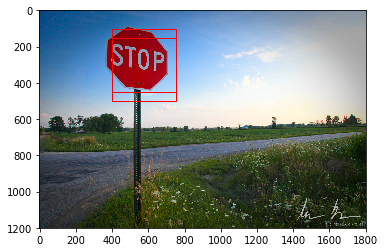

In [563]:
url = 'data/stop.jpg'
magic(url, window_size=350, step=50, threshold=.999)

[(401, 651, 300, 'Motorbikes', 0.99915051)]


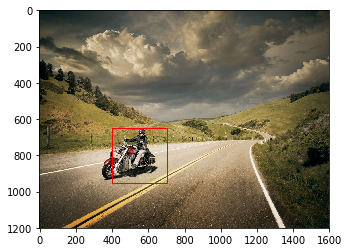

In [564]:
url = 'data/motor.jpg'
magic(url, window_size=300, step=50, threshold=.999)

[(221, 161, 250, 'bill_gates', 0.99861491)]


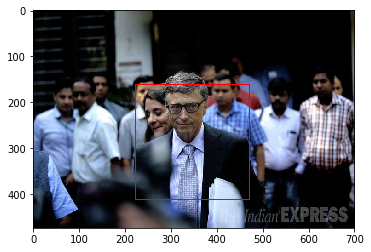

In [597]:
url = 'data/bill.jpg'
magic(url, window_size=250, step=20, threshold=.998)

In [ ]:
# CASE STUDIES

## Anomoly Detection

“An outlier is an observation in a data set which appears to be inconsistent with the remainder of that set of data.”

* Supervised Anomoly Detection
    * Labels available for both normal data and anomalies
    * Similar to rare class mining / imbalanced classification

* Unsupervised Anomoly Detection (Outlier Detection)
    * no labels, training set = normal + abnormal data • Assumption: anomalies are very rare

* Semi-supervised Anomoly Detection (Novelty Detection)
    * Only normal data available to train
    * The algorithm learns on normal data only

In [ ]:
# Supervised and Outlier Detection with KDD

In [108]:
from sklearn.model_selection import train_test_split

y_binary = y != 'normal.'

X_train, X_test, y_train, y_test = train_test_split(X, y_binary)

In [109]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_jobs=-1)
model.fit(X_train)  # notice that there is no y in the .fit

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=None,
        verbose=0)

In [121]:
y_predicted = model.predict(X_test)

In [128]:
from sklearn.metrics import accuracy_score

accuracy_score(y_predicted, y_test)

0.7423687917995887

In [130]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train, y_train)

accuracy_score(lr.predict(X_test), y_test)  # better than the anomoly detection, but its because this is supervised

0.98621929298981426

In [ ]:
import scipy
scipy.io.loadmat()